In [24]:
import numpy as np
import pandas as pd
from scipy.special import expit

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, precision_score, recall_score
from sklearn.base import clone as sk_clone

import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from lingam import DirectLiNGAM, BottomUpParceLiNGAM, VARLiNGAM
from lingam import CausalBasedSimulator
from lingam.utils import make_dot

np.random.seed(0)

## 1. 実験用関数

### 1.1. 因果デジタルツインのクラス

In [2]:
class CausalDigitalTwin:
    
    def __init__(self, causal_graph, X, sink_index, is_discrete=None, cd_algo_name="DirectLiNGAM"):        
        sim = CausalBasedSimulator()
        sim.train(X, causal_graph, cd_algo_name=cd_algo_name, is_discrete=is_discrete)
        
        self._sim = sim
        self._causal_graph = causal_graph
        self._X = X
        self._sink_index = sink_index
        self._is_discrete = is_discrete
    
    def run(self, ml_models, causal_graph=None, error=None, shuffle_residual=False):
        """
        Arguments
        ---------
        causal_graph : array-like
        error : dict
        ml_models : dict
        
        Return
        ------
        evaluated
        """
        
        if causal_graph is None:
            changing_models = None
        else:
            changing_models = self._make_changing_models(self._causal_graph, causal_graph)
            
        if error is None:
            changing_exog = None
        else:
            changing_exog = {i: error[:, i].ravel() for i in range(error.shape[1])}
        
        simulated = self._sim.run(changing_models=changing_models, changing_exog=changing_exog, shuffle_residual=shuffle_residual)
        
        # Xは変更前の真データ、X_afterは変更後の真データ。X_afterは変化した因果グラフに基づいて作成する。
        X_after = 

        evals, predicted_values = self._evaluate(self._X, simulated, self._sink_index, ml_models, self._is_discrete)
        
        return evals, predicted_values, simulated
    
    def _make_changing_models(self, causal_graph, causal_graph2):
        # 未観測共通原因は0にしておく
        causal_graph[np.isnan(causal_graph)] = 0
        causal_graph2[np.isnan(causal_graph2)] = 0
        
        # 変数名のリスト
        if len(causal_graph.shape) == 2:
            var_names = [f"{i}" for i in range(len(causal_graph))]
        else:
            n_dags, n_features, _ = causal_graph.shape
            var_names = []
            for i in range(n_dags):
                if i == 0:
                    var_names += [f"{j}[t]" for j in range(n_features)]
                else:
                    var_names += [f"{j}[t-{i}]" for j in range(n_features)]
        
        # VARの形式の時は隣接行列を変更
        if len(causal_graph.shape) > 2:
            causal_graph = np.concatenate(causal_graph, axis=1)
            causal_graph2 = np.concatenate(causal_graph2, axis=1)
        
        # グラフの構造の変化からchanging_modelsを作成する。
        changed = ~np.isclose(causal_graph - causal_graph2, 0)

        # 説明変数の係数に変化を含む行を対象として処理
        changing_models = {}
        for i, row in enumerate(changed):
            # 変化なしはパス
            if np.isclose(np.sum(row), 0):
                continue

            # 変更後のDAGに従って親変数とその係数値を改めて設定する。
            parent_indices = np.argwhere(~np.isclose(causal_graph2[i], 0)).ravel()
            parent_names = [var_names[j] for j in parent_indices]
            coefs = causal_graph2[i, parent_indices] if len(parent_indices) != 0 else []
            changing_models[var_names[i]] = {"parent_names": parent_names, "coef": coefs}
        if len(changing_models) == 0:
            changing_models = None
            
        return changing_models
    
    def _evaluate(self, X, simulated, sink_index, ml_models, is_discrete):     
        evals = {}
        predicted_values = {}
        for name, ml_model in ml_models.items():
            # 変更前データの機械学習
            X_ = np.delete(X, sink_index, axis=1)
            y_ = X[:, sink_index]
            ml_model.fit(X_, y_)
            predicted = ml_model.predict(X_)

            # 変更後シミュレーションデータの機械学習
            X_ = np.delete(simulated, sink_index, axis=1)
            y_ = simulated.iloc[:, sink_index]
            ml_model2 = sk_clone(ml_model)
            ml_model2.fit(X_, y_)
            predicted2 = ml_model.predict(X_)
            
            # 変更前データのモデルで、変更後データを予測した場合
            predicted3 = ml_model.predict(X_)

            # 評価
            if is_discrete is None or not is_discrete[sink_index]:
                eval_funcs = [("mse", mean_squared_error)]
            else:
                eval_funcs = [("precision", precision_score), ("recall", recall_score)]
                
            for eval_name, eval_func in eval_funcs:
                # 変更前：真のデータに基づく機械学習モデルの予測結果と、真のデータの評価値
                eval_value = eval_func(X[:, sink_index], predicted)
                evals[(name, eval_name, "true")] = eval_value

                # 変更後：シミュレーションデータに基づく機械学習モデルの予測結果と、真のシミュレーションデータの評価値
                eval_value2 = eval_func(simulated.iloc[:, sink_index], predicted2)
                evals[(name, eval_name, "sim")] = eval_value2
                
                # 変更前のモデルで変更後を予測
                eval_value3 = eval_func(simulated.iloc[:, sink_index], predicted3)
                evals[(name, eval_name, "true_sim")] = eval_value3

            predicted_values[(name, "true")] = {"true": X[:, sink_index], "pred": predicted}
            predicted_values[(name, "sim")] = {"true": simulated.iloc[:, sink_index], "pred": predicted2}
        return evals, predicted_values

### 1.2. データ生成のための関数

In [3]:
def generate_test_data(causal_graph, causal_order, ratio_list, size=1000):
    """ 誤差項の分散が指定の割合になるように係数を調整しながらデータを生成する。
    
    Arguments
    ---------
    causal_graph
        因果グラフ
    raito_list
        各変数における誤差項の分散の割合
    causal_order
        因果順序
    e
        誤差項
    Return
    ------
    X
        データ
    causal_graph
        係数を調整した因果グラフ
    """
    n_features = len(causal_graph)
    
    # generate errors
    e = np.empty((n_features, size))
    for i, ratio in enumerate(ratio_list):
        a = np.sqrt(3 * ratio)
        e[i] = np.random.uniform(-a, a, size=size)

    # generate data
    X = np.zeros((n_features, size))
    for no in causal_order:
        if np.all(np.isclose(causal_graph[no], 0)):
            X[no] = e[no]
            continue
            
        # adjust coefs
        var = np.var(causal_graph[no] @ X)
        causal_graph[no] = causal_graph[no] / np.sqrt(var) * np.sqrt(1 - ratio_list[no])
    
        # generate
        X[no] = causal_graph[no] @ X + e[no]
    
    return X.T, causal_graph, e.T

def discretize(causal_graph, X, sink_index):
    """ X[:, sink_index] を離散化する。 """
    prob = expit(X[:, sink_index])
    mask = np.random.uniform(size=len(X))
    X[:, sink_index] = prob > mask
    return X

## 1. DirectLiNGAM

### 1.1. データ作成

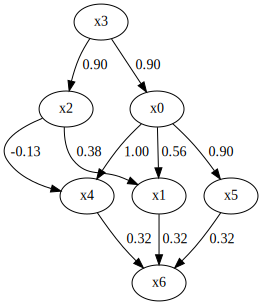

In [4]:
# 元の隣接行列は次と同じ：https://github.com/cdt15/lingam/blob/master/examples/DirectLiNGAM.ipynb
cg_not_adjusted = np.array([
    [0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0],
    [3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [8.0, 0.0,-1.0, 0.0, 0.0, 0.0, 0.0],
    [4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0],
])
# 因果順序
causal_order = [3, 0, 2, 1, 4, 5, 6]
# 各変数の分散に占める誤差項の分散の比率
ratio_list = [0.2, 0.2, 0.2, 1.0, 0.2, 0.2, 0.2]
# シンク変数のインデックス
sink_index = 6

# 係数の調整
X, causal_graph_true, e_true = generate_test_data(cg_not_adjusted, causal_order, ratio_list, size=1000)

display(make_dot(causal_graph_true, lower_limit=0))

# データ生成関数
def data_gen_direct_lingam(causal_graph, error):
    X = (np.linalg.pinv(np.eye(len(causal_graph)) - causal_graph) @ errors.T).T
    return X, error

### 1.2. 実験

In [5]:
# 実験間で共通のデータ

# 誤差項
errors = []
for ratio in ratio_list:
    a = np.sqrt(3 * ratio)
    errors.append(np.random.uniform(-a, a, size=1000))
errors = np.array(errors).T
    
errors2 = []
for ratio in ratio_list:
    a = np.sqrt(3 * ratio)
    errors2.append(np.random.uniform(-a, a, size=1000))
errors2 = np.array(errors2).T

# 機械学習モデル
#param_grid = {"n_estimators": [1, 2, 3]}
param_grid = {"n_estimators": [50, 100, 200]}
ml_models_c = {"lr": LinearRegression(), "rf": GridSearchCV(RandomForestRegressor(), param_grid)}
ml_models_d = {"lr": LogisticRegression(), "rf": GridSearchCV(RandomForestClassifier(), param_grid)}

# 離散変数
is_discrete = [False for _ in range(len(causal_graph_true))]
is_discrete[sink_index] = True

# 実験の設定
test_info = []

# 各実験の設定作成

# 実験1: エッジ削除 (x3->x2, x0->x4を削除)
causal_graph = causal_graph_true.copy()
causal_graph[2, 3] = 0
causal_graph[4, 0] = 0

test_info.append({
    "name": "remove",
    "modified_causal_graph": causal_graph,
})

# 実験2: エッジ追加 (x0->x2, x3->x4を追加)
causal_graph = causal_graph_true.copy()
causal_graph[2, 0] = 1
causal_graph[4, 3] = 1

test_info.append({
    "name": "add",
    "modified_causal_graph": causal_graph,
})

# 実験3: エッジ係数値の変更 (x2->x1を10倍に設定)
causal_graph = causal_graph_true.copy()
causal_graph[1, 2] *= 10

test_info.append({
    "name": "modify",
    "modified_causal_graph": causal_graph,
})

# 実験を行っていく
results = {}
for info in test_info:
    # sinkが連続
    X, error_ = data_gen_direct_lingam(causal_graph_true, errors)
    cdt = CausalDigitalTwin(causal_graph_true, X, sink_index)
    result = cdt.run(ml_models_c, causal_graph=info["modified_causal_graph"])
    
    print(info["name"], "cv_results_(continuous)", ml_models_c["rf"].best_params_)
    
    # sinkが連続&シャッフル
    result_shuffle = cdt.run(ml_models_c, causal_graph=info["modified_causal_graph"], shuffle_residual=True)
    
    # sinkが離散
    X_d, error_ = data_gen_direct_lingam(causal_graph_true, errors)
    X_d = discretize(causal_graph, X_d, sink_index)
    cdt = CausalDigitalTwin(causal_graph_true, X_d, sink_index, is_discrete=is_discrete)
    result_d = cdt.run(ml_models_d, causal_graph=info["modified_causal_graph"])
    
    print(info["name"], "cv_results_(discrete)", ml_models_d["rf"].best_params_)
    
    # sinkが離散&シャッフル
    result_d_shuffle = cdt.run(ml_models_d, causal_graph=info["modified_causal_graph"], shuffle_residual=True)
    
    # 値はCausalDigitalTwin.run()の返り値に正解データを足したもの。 
    # 値： evals, predicted_values, simulated, X
    results[info["name"]] = {
        "continuous": (*result, X),
        "continuous_shuffle": (*result_shuffle, X),
        "discrete": (*result_d, X_d),
        "discrete_shuffle": (*result_d_shuffle, X_d),
    }

remove cv_results_(continuous) {'n_estimators': 100}
remove cv_results_(discrete) {'n_estimators': 100}
add cv_results_(continuous) {'n_estimators': 100}
add cv_results_(discrete) {'n_estimators': 100}
modify cv_results_(continuous) {'n_estimators': 200}
modify cv_results_(discrete) {'n_estimators': 100}


### 1.3. 実験結果

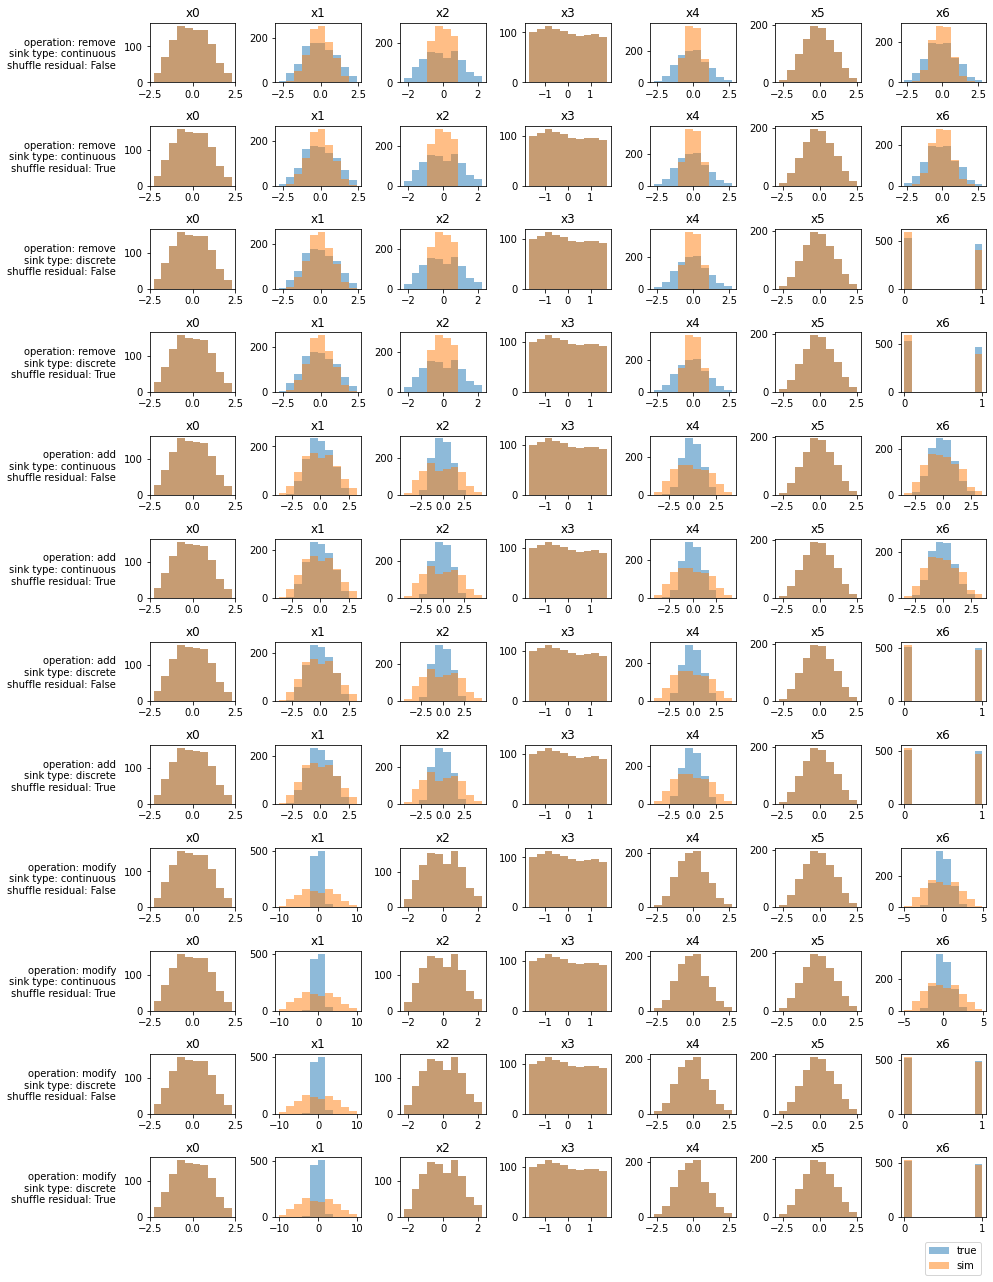

In [6]:
# シミュレーションの様子
n_features = len(causal_graph_true)
n_patterns = len(results) * len(results["add"])

fig, axes = plt.subplots(n_patterns, n_features, figsize=(n_features*2, n_patterns*1.5))
count = 0

for name, result in results.items():
    for name2, result2 in result.items():
        evals, predicted_values, simulated, X = result2
        
        ax = axes[count]
        for i, (true, sim) in enumerate(zip(X.T, simulated.values.T)):
            range_ = min(*true, *sim), max(*true, *sim)
            ax[i].hist(true, range=range_, label="true", alpha=0.5)
            ax[i].hist(sim, range=range_, label="sim", alpha=0.5)
            ax[i].set_title(f"x{i}")
        
            if count == 0:
                ax[i].set_title(f"x{i}")
            if i == 0:
                s = "operation: " + name + "\n"
                s += "sink type: " + name2.split("_")[0] + "\n"
                s += "shuffle residual: " + ("True" if len(name2.split("_")) == 2 else "False") + "\n"
                ax[i].text(-4.5, 0, s, ha="right", va="bottom")
            if count == n_patterns - 1 and i == n_features - 1:
                ax[i].legend(bbox_to_anchor=(1, -0.7), loc="center right")
        count += 1

plt.tight_layout()
plt.show()

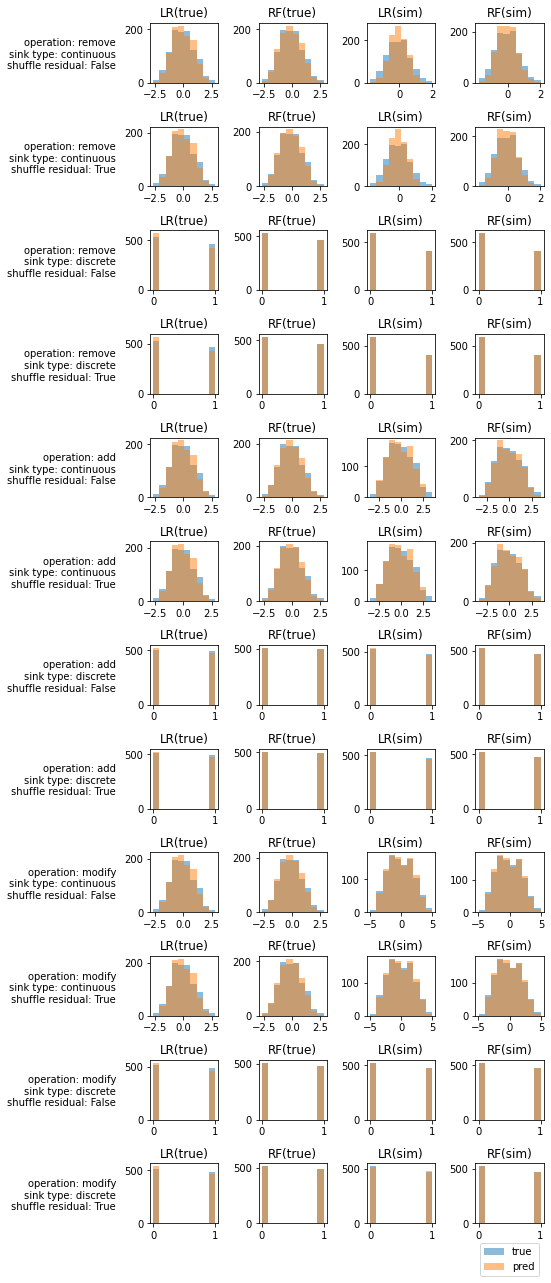

In [7]:
# 機械学習による予測の様子
n_features = len(causal_graph_true)
n_patterns = len(results) * len(results["add"])
n_rows = 4

fig, axes = plt.subplots(n_patterns, n_rows, figsize=(n_rows*2, n_patterns*1.5))
count = 0

for name, result in results.items():
    for name2, result2 in result.items():
        evals, predicted_values, simulated, X = result2
        
        ax = axes[count]

        def _draw_hist(ax, true, pred):
            range_ = min(*true, *pred), max(*true, *pred)
            ax.hist(true, alpha=0.5, label="true", range=range_)
            ax.hist(pred, alpha=0.5, label="pred", range=range_)
        
        # 真のデータに対する機械学習
        values = predicted_values[("lr", "true")]
        _draw_hist(ax[0], values["true"], values["pred"])
        ax[0].set_title("LR(true)")
        values = predicted_values[("rf", "true")]
        _draw_hist(ax[1], values["true"], values["pred"])
        ax[1].set_title("RF(true)")
        
        # シミュレーションデータに対する機械学習
        values = predicted_values[("lr", "sim")]
        _draw_hist(ax[2], values["true"], values["pred"])
        ax[2].set_title("LR(sim)")
        values = predicted_values[("rf", "sim")]
        _draw_hist(ax[3], values["true"], values["pred"])
        ax[3].set_title("RF(sim)")
                
        # 実験条件
        l, r = ax[0].get_xlim()
        offset = (r - l) * 0.5
        s = "operation: " + name + "\n"
        s += "sink type: " + name2.split("_")[0] + "\n"
        s += "shuffle residual: " + ("True" if len(name2.split("_")) == 2 else "False") + "\n"
        ax[0].text(l - offset, 0, s, ha="right", va="bottom")
        
        if count == n_patterns - 1:
            ax[3].legend(bbox_to_anchor=(1, -0.6), loc="center right")
            
        count += 1

plt.tight_layout()
plt.show()

In [8]:
# 結果の表(連続)
table = []
columns = ["operation", "model", "shuffle error", "MSE(true)", "MSE(sim)"]

for name, result in results.items():
    for name2, result2 in result.items():
        if not name2.startswith("continuous"):
            continue
        
        evals, predicted_values, simulated, X = result2
        
        is_shuffle = len(name2.split("_")) > 1
        
        # lr
        mse_true = evals[('lr', 'mse', 'true')]
        mse_sim = evals[('lr', 'mse', 'sim')]
        table.append((name, "LinearRegression", str(is_shuffle), f"{mse_true:.3f}", f"{mse_sim:.3f}"))
        
        # rf
        mse_true = evals[('rf', 'mse', 'true')]
        mse_sim = evals[('rf', 'mse', 'sim')]
        table.append((name, "RandomForestRegressor", str(is_shuffle), f"{mse_true:.3f}", f"{mse_sim:.3f}"))
        
pd.DataFrame(table, columns=columns).style.hide(axis="index")

operation,model,shuffle error,MSE(true),MSE(sim)
remove,LinearRegression,False,0.198,0.198
remove,RandomForestRegressor,False,0.031,0.031
remove,LinearRegression,True,0.198,0.198
remove,RandomForestRegressor,True,0.030,0.031
add,LinearRegression,False,0.198,0.198
add,RandomForestRegressor,False,0.031,0.031
add,LinearRegression,True,0.198,0.198
add,RandomForestRegressor,True,0.031,0.031
modify,LinearRegression,False,0.198,0.198
modify,RandomForestRegressor,False,0.031,0.033


In [9]:
# 結果の表(離散)
table = []
columns = ["operation", "model", "shuffle error", "precision(true)", "precision(sim)", "recall(true)", "recall(sim)"]

for name, result in results.items():
    for name2, result2 in result.items():
        if not name2.startswith("discrete"):
            continue
        
        evals, predicted_values, simulated, X = result2
        
        is_shuffle = len(name2.split("_")) > 1
        
        # lr
        precision_true = evals[('lr', 'precision', 'true')]
        precision_sim = evals[('lr', 'precision', 'sim')]
        recall_true = evals[('lr', 'recall', 'true')]
        recall_sim = evals[('lr', 'recall', 'sim')]
        table.append(
            (name, "LinearRegression", str(is_shuffle),
             f"{precision_true:.3f}", f"{precision_sim:.3f}", f"{recall_true:.3f}", f"{recall_sim:.3f}")
        )
        
        # rf
        precision_true = evals[('rf', 'precision', 'true')]
        precision_sim = evals[('rf', 'precision', 'sim')]
        recall_true = evals[('rf', 'recall', 'true')]
        recall_sim = evals[('rf', 'recall', 'sim')]
        table.append(
            (name, "RandomForestRegressor", str(is_shuffle),
             f"{precision_true:.3f}", f"{precision_sim:.3f}", f"{recall_true:.3f}", f"{recall_sim:.3f}")
        )
        
pd.DataFrame(table, columns=columns).style.hide(axis="index")

operation,model,shuffle error,precision(true),precision(sim),recall(true),recall(sim)
remove,LinearRegression,False,0.678,0.983,0.618,0.985
remove,RandomForestRegressor,False,1.000,1.000,1.000,1.000
remove,LinearRegression,True,0.678,0.983,0.618,0.985
remove,RandomForestRegressor,True,1.000,1.000,1.000,1.000
add,LinearRegression,False,0.681,0.998,0.656,0.981
add,RandomForestRegressor,False,1.000,1.000,1.000,1.000
add,LinearRegression,True,0.681,0.998,0.656,0.981
add,RandomForestRegressor,True,1.000,1.000,1.000,1.000
modify,LinearRegression,False,0.673,0.994,0.639,1.000
modify,RandomForestRegressor,False,1.000,1.000,1.000,1.000


## 2. BottomUpParceLiNGAM

### 2.1. データ作成

DirectLiNGAMと同じ構造でデータを作成し、その後、x3を未観測化する。

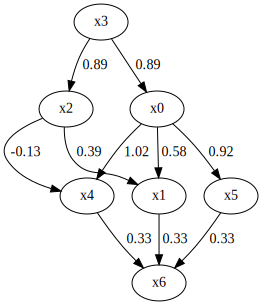

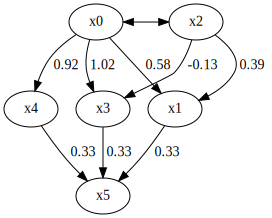

In [10]:
cg_not_adjusted = np.array([
    [0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0],
    [3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [8.0, 0.0,-1.0, 0.0, 0.0, 0.0, 0.0],
    [4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0],
])
causal_order = [3, 0, 2, 1, 4, 5, 6]
ratio_list = [0.2, 0.2, 0.2, 1.0, 0.2, 0.2, 0.2]
sink_index = 6
X, causal_graph_true, e_true = generate_test_data(cg_not_adjusted, causal_order, ratio_list, size=1000)

display(make_dot(causal_graph_true, lower_limit=0))

# DirectLiNGAMとまったく同じなので省略

# 未観測化
delete_index = 3
causal_graph_true_unobs = causal_graph_true.copy()
causal_graph_true_unobs = np.delete(causal_graph_true_unobs, delete_index, axis=0)
causal_graph_true_unobs = np.delete(causal_graph_true_unobs, delete_index, axis=1)
causal_graph_true_unobs[0, 2] = np.nan
causal_graph_true_unobs[2, 0] = np.nan
display(make_dot(causal_graph_true_unobs, lower_limit=0))
sink_index_unobs = 5

# データ生成関数：未観測化はこの関数内で行う
def data_gen_unobs_common(causal_graph, errors):
    delete_index = 3
    
    X = (np.linalg.pinv(np.eye(len(causal_graph)) - causal_graph) @ errors.T).T
    X = np.delete(X, delete_index, axis=0)
    X = np.delete(X, delete_index, axis=1)
    
    errors = np.delete(errors, delete_index, axis=1)
    
    return X, errors

### 2.2. 実験

In [11]:
# 実験間で共通のデータ

# 誤差項
errors = []
for ratio in ratio_list:
    a = np.sqrt(3 * ratio)
    errors.append(np.random.uniform(-a, a, size=1000))
errors = np.array(errors).T
    
errors2 = []
for ratio in ratio_list:
    a = np.sqrt(3 * ratio)
    errors2.append(np.random.uniform(-a, a, size=1000))
errors2 = np.array(errors2).T

# 機械学習モデル
#param_grid = {"n_estimators": [1, 2, 3]}
param_grid = {"n_estimators": [50, 100, 200]}
ml_models_c = {"lr": LinearRegression(), "rf": GridSearchCV(RandomForestRegressor(), param_grid)}
ml_models_d = {"lr": LogisticRegression(), "rf": GridSearchCV(RandomForestClassifier(), param_grid)}

# 離散変数
is_discrete = [False for _ in range(len(causal_graph_true_unobs))]
is_discrete[sink_index_unobs] = True

# 実験の設定
test_info = []

# 各実験の設定作成

# 実験1: エッジ削除 (x2->x1を削除)
causal_graph = causal_graph_true_unobs.copy()
causal_graph[1, 2] = 0

test_info.append({
    "name": "remove",
    "modified_causal_graph": causal_graph,
})

# 実験2: エッジ追加 (x1->x3を追加)
causal_graph = causal_graph_true_unobs.copy()
causal_graph[3, 1] = 1

test_info.append({
    "name": "add",
    "modified_causal_graph": causal_graph,
})

# 実験3: エッジ係数値の変更 (x0->x3を10倍に設定)
causal_graph = causal_graph_true_unobs.copy()
causal_graph[3, 0] *= 10

test_info.append({
    "name": "modify",
    "modified_causal_graph": causal_graph,
})

# 実験を行っていく
results = {}
for info in test_info:
    # sinkが連続
    X, error_ = data_gen_unobs_common(causal_graph_true, errors)
    cdt = CausalDigitalTwin(causal_graph_true_unobs, X, sink_index_unobs, cd_algo_name="BottomUpParceLiNGAM")
    result = cdt.run(ml_models_c, causal_graph=info["modified_causal_graph"])
    
    print(info["name"], "cv_results_(continuous)", ml_models_c["rf"].best_params_)
    
    # sinkが連続&シャッフル
    result_shuffle = cdt.run(ml_models_c, causal_graph=info["modified_causal_graph"], shuffle_residual=True)
    
    # sinkが離散
    X_d, error_ = data_gen_unobs_common(causal_graph_true, errors)
    X_d = discretize(causal_graph, X_d, sink_index_unobs)
    cdt = CausalDigitalTwin(causal_graph_true_unobs, X_d, sink_index_unobs, is_discrete=is_discrete, cd_algo_name="BottomUpParceLiNGAM")
    result_d = cdt.run(ml_models_d, causal_graph=info["modified_causal_graph"])
    
    print(info["name"], "cv_results_(discrete)", ml_models_d["rf"].best_params_)

    # sinkが離散&シャッフル
    result_d_shuffle = cdt.run(ml_models_d, causal_graph=info["modified_causal_graph"], shuffle_residual=True)

    results[info["name"]] = {
        "continuous": (*result, X),
        "continuous_shuffle": (*result_shuffle, X),
        "discrete": (*result_d, X_d),
        "discrete_shuffle": (*result_d_shuffle, X_d),
    }

remove cv_results_(continuous) {'n_estimators': 200}
remove cv_results_(discrete) {'n_estimators': 100}
add cv_results_(continuous) {'n_estimators': 200}
add cv_results_(discrete) {'n_estimators': 200}
modify cv_results_(continuous) {'n_estimators': 200}
modify cv_results_(discrete) {'n_estimators': 50}


### 2.3. 実験結果

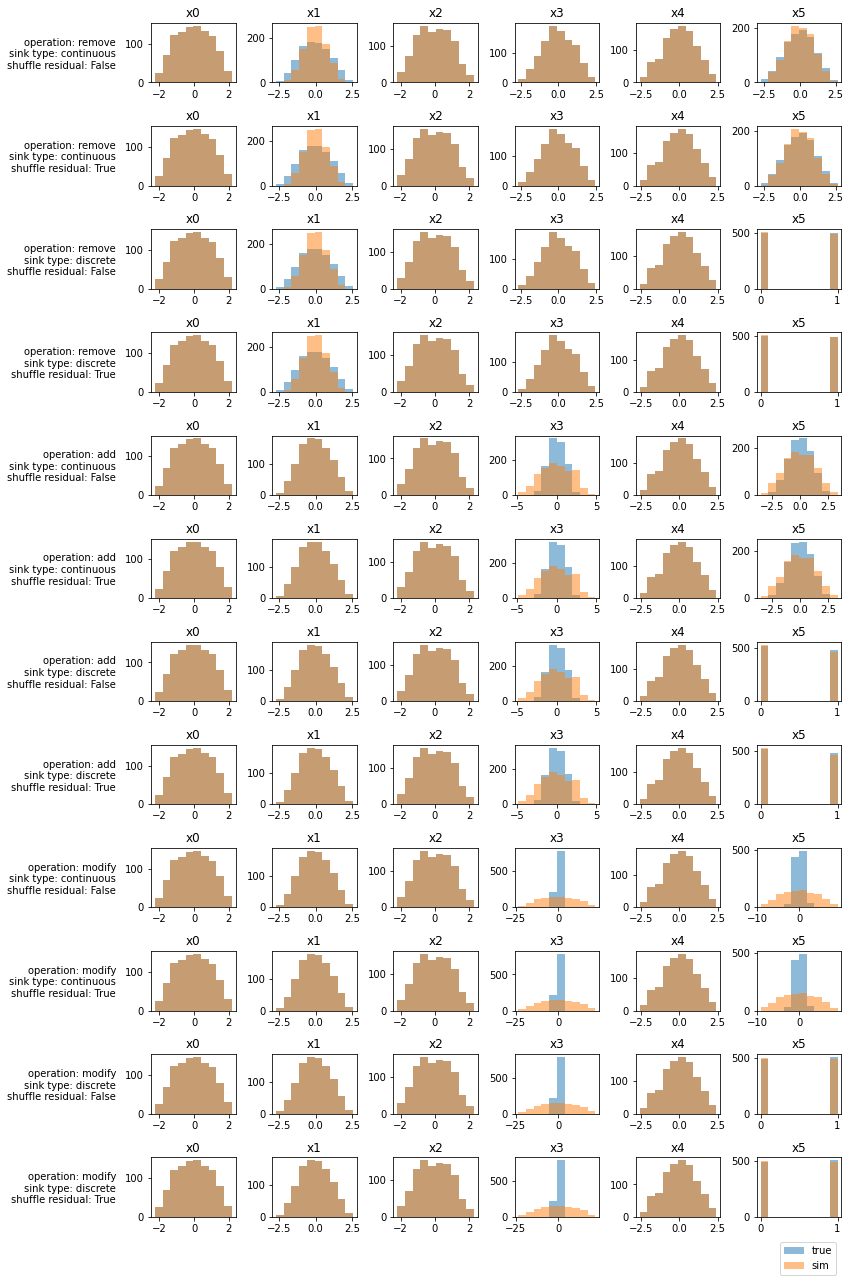

In [12]:
# シミュレーションの様子
n_features = len(causal_graph_true_unobs)
n_patterns = len(results) * len(results["add"])

fig, axes = plt.subplots(n_patterns, n_features, figsize=(n_features*2, n_patterns*1.5))
count = 0

for name, result in results.items():
    for name2, result2 in result.items():
        evals, predicted_values, simulated, X = result2
        
        ax = axes[count]
        for i, (true, sim) in enumerate(zip(X.T, simulated.values.T)):
            range_ = min(*true, *sim), max(*true, *sim)
            ax[i].hist(true, range=range_, label="true", alpha=0.5)
            ax[i].hist(sim, range=range_, label="sim", alpha=0.5)
            ax[i].set_title(f"x{i}")
        
            if count == 0:
                ax[i].set_title(f"x{i}")
            if i == 0:
                s = "operation: " + name + "\n"
                s += "sink type: " + name2.split("_")[0] + "\n"
                s += "shuffle residual: " + ("True" if len(name2.split("_")) == 2 else "False") + "\n"
                ax[i].text(-4.5, 0, s, ha="right", va="bottom")
            if count == n_patterns - 1 and i == n_features - 1:
                ax[i].legend(bbox_to_anchor=(1, -0.7), loc="center right")
        count += 1

plt.tight_layout()
plt.show()

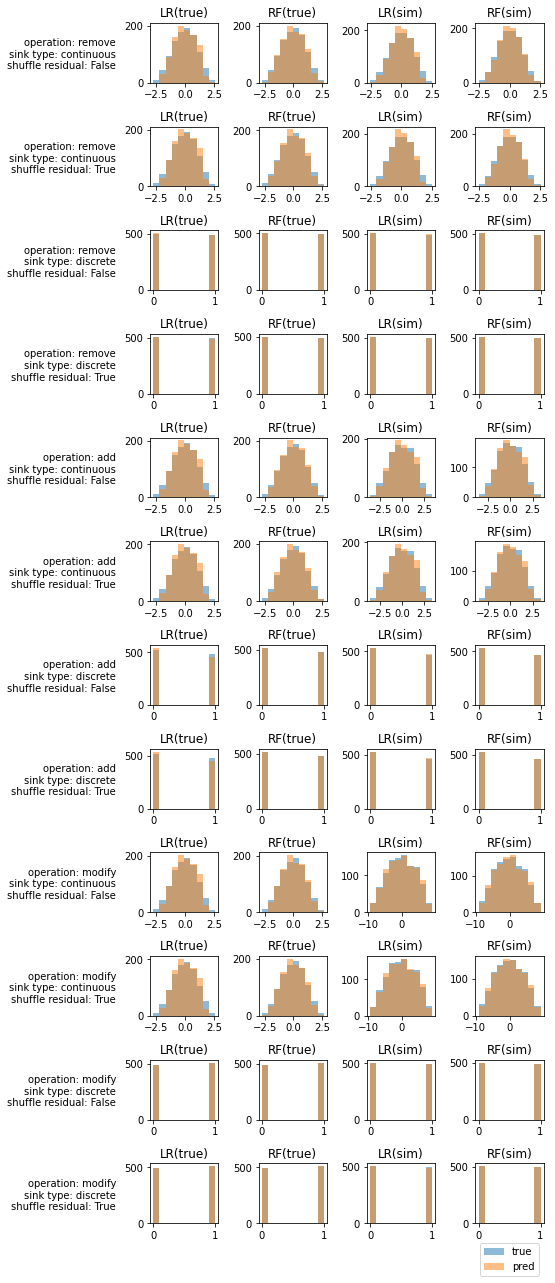

In [13]:
# 機械学習による予測の様子
n_features = len(causal_graph_true)
n_patterns = len(results) * len(results["add"])
n_rows = 4

fig, axes = plt.subplots(n_patterns, n_rows, figsize=(n_rows*2, n_patterns*1.5))
count = 0

for name, result in results.items():
    for name2, result2 in result.items():
        evals, predicted_values, simulated, X = result2
        
        ax = axes[count]

        def _draw_hist(ax, true, pred):
            range_ = min(*true, *pred), max(*true, *pred)
            ax.hist(true, alpha=0.5, label="true", range=range_)
            ax.hist(pred, alpha=0.5, label="pred", range=range_)
        
        # 真のデータに対する機械学習
        values = predicted_values[("lr", "true")]
        _draw_hist(ax[0], values["true"], values["pred"])
        ax[0].set_title("LR(true)")
        values = predicted_values[("rf", "true")]
        _draw_hist(ax[1], values["true"], values["pred"])
        ax[1].set_title("RF(true)")
        
        # シミュレーションデータに対する機械学習
        values = predicted_values[("lr", "sim")]
        _draw_hist(ax[2], values["true"], values["pred"])
        ax[2].set_title("LR(sim)")
        values = predicted_values[("rf", "sim")]
        _draw_hist(ax[3], values["true"], values["pred"])
        ax[3].set_title("RF(sim)")
                
        # 実験条件
        l, r = ax[0].get_xlim()
        offset = (r - l) * 0.5
        s = "operation: " + name + "\n"
        s += "sink type: " + name2.split("_")[0] + "\n"
        s += "shuffle residual: " + ("True" if len(name2.split("_")) == 2 else "False") + "\n"
        ax[0].text(l - offset, 0, s, ha="right", va="bottom")
        
        if count == n_patterns - 1:
            ax[3].legend(bbox_to_anchor=(1, -0.6), loc="center right")
            
        count += 1

plt.tight_layout()
plt.show()

In [14]:
# 結果の表(連続)
table = []
columns = ["operation", "model", "shuffle error", "MSE(true)", "MSE(sim)"]

for name, result in results.items():
    for name2, result2 in result.items():
        if not name2.startswith("continuous"):
            continue
        
        evals, predicted_values, simulated, X = result2
        
        is_shuffle = len(name2.split("_")) > 1
        
        # lr
        mse_true = evals[('lr', 'mse', 'true')]
        mse_sim = evals[('lr', 'mse', 'sim')]
        table.append((name, "LinearRegression", str(is_shuffle), f"{mse_true:.3f}", f"{mse_sim:.3f}"))
        
        # rf
        mse_true = evals[('rf', 'mse', 'true')]
        mse_sim = evals[('rf', 'mse', 'sim')]
        table.append((name, "RandomForestRegressor", str(is_shuffle), f"{mse_true:.3f}", f"{mse_sim:.3f}"))
        
pd.DataFrame(table, columns=columns).style.hide(axis="index")

operation,model,shuffle error,MSE(true),MSE(sim)
remove,LinearRegression,False,0.194,0.194
remove,RandomForestRegressor,False,0.031,0.031
remove,LinearRegression,True,0.194,0.194
remove,RandomForestRegressor,True,0.031,0.031
add,LinearRegression,False,0.194,0.194
add,RandomForestRegressor,False,0.031,0.031
add,LinearRegression,True,0.194,0.194
add,RandomForestRegressor,True,0.032,0.032
modify,LinearRegression,False,0.194,0.194
modify,RandomForestRegressor,False,0.032,0.034


In [15]:
# 結果の表(離散)
table = []
columns = ["operation", "model", "shuffle error", "precision(true)", "precision(sim)", "recall(true)", "recall(sim)"]

for name, result in results.items():
    for name2, result2 in result.items():
        if not name2.startswith("discrete"):
            continue
        
        evals, predicted_values, simulated, X = result2
        
        is_shuffle = len(name2.split("_")) > 1
        
        # lr
        precision_true = evals[('lr', 'precision', 'true')]
        precision_sim = evals[('lr', 'precision', 'sim')]
        recall_true = evals[('lr', 'recall', 'true')]
        recall_sim = evals[('lr', 'recall', 'sim')]
        table.append(
            (name, "LogisticRegression", str(is_shuffle),
             f"{precision_true:.3f}", f"{precision_sim:.3f}", f"{recall_true:.3f}", f"{recall_sim:.3f}")
        )
        
        # rf
        precision_true = evals[('rf', 'precision', 'true')]
        precision_sim = evals[('rf', 'precision', 'sim')]
        recall_true = evals[('rf', 'recall', 'true')]
        recall_sim = evals[('rf', 'recall', 'sim')]
        table.append(
            (name, "RandomForestRegressor", str(is_shuffle),
             f"{precision_true:.3f}", f"{precision_sim:.3f}", f"{recall_true:.3f}", f"{recall_sim:.3f}")
        )
        
pd.DataFrame(table, columns=columns).style.hide(axis="index")

operation,model,shuffle error,precision(true),precision(sim),recall(true),recall(sim)
remove,LogisticRegression,False,0.653,0.992,0.645,0.998
remove,RandomForestRegressor,False,1.000,1.000,1.000,1.000
remove,LogisticRegression,True,0.653,0.992,0.645,0.998
remove,RandomForestRegressor,True,1.000,1.000,1.000,1.000
add,LogisticRegression,False,0.660,0.987,0.626,0.998
add,RandomForestRegressor,False,1.000,1.000,1.000,1.000
add,LogisticRegression,True,0.660,0.987,0.626,0.998
add,RandomForestRegressor,True,1.000,1.000,1.000,1.000
modify,LogisticRegression,False,0.663,1.000,0.662,0.998
modify,RandomForestRegressor,False,1.000,1.000,1.000,1.000


## 3. VARLiNGAM

### 3.1. データ作成

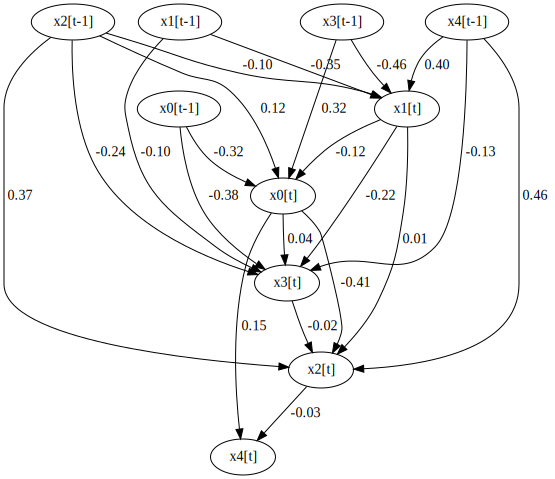

In [16]:
# 元の隣接行列は次と同じ：https://github.com/cdt15/lingam/blob/master/examples/VARLiNGAM.ipynb
causal_graph_true = np.array([
    [
        [0,-0.12,0,0,0],
        [0,0,0,0,0],
        [-0.41,0.01,0,-0.02,0],
        [0.04,-0.22,0,0,0],
        [0.15,0,-0.03,0,0],
    ],
    [
        [-0.32,0,0.12,0.32,0],
        [0,-0.35,-0.1,-0.46,0.4],
        [0,0,0.37,0,0.46],
        [-0.38,-0.1,-0.24,0,-0.13],
        [0,0,0,0,0],
    ]
])
n_features = causal_graph_true.shape[1]
n_lags = len(causal_graph_true) - 1

concated = np.zeros((n_features * len(causal_graph_true), n_features * len(causal_graph_true)))
concated[:n_features, :] = np.concatenate(causal_graph_true, axis=1)
labels = [f"x{i}[t]" for i in range(n_features)] + [f"x{i}[t-1]" for i in range(n_features)]
display(make_dot(concated, labels=labels, lower_limit=0))

causal_order = [1, 0, 3, 2, 4]
# XXX: 誤差項の分散の占める割合を調整できないため、すべて1とする。
ratio_list = [1, 1, 1, 1, 1]

sink_index = 4

def data_gen_time_series(causal_graph, errors):
    def x_t(X, e, B):
        _, n_features, _ = B.shape
        
        # (I - B_0)^-1
        term = np.linalg.pinv(np.eye(n_features) - B[0])

        # Sigma[B_tau @ x(t-tau)] + e(t)
        # Bは横につなげて、Xは縦につなげる
        # Bの2番目以降を横に連結、Xの最新からBの2番目以降との積をとる部分を縦に連結して、行列の積
        term2 = np.hstack(B[1:]) @ np.hstack(X[:, ::-1][:, :len(B) - 1]).reshape(n_features, 1) + e

        return term @ term2
    
    sample_size = 1000
    
    n_lags = len(causal_graph) - 1
    size = len(errors) - n_lags
    
    errors = errors.T
    
    X = errors[:, :n_lags]
    for t in range(n_lags, sample_size):
        new_data = x_t(X[:, :t], errors[:, [t]], causal_graph)
        X = np.append(X, new_data, axis=1)
    
    return X.T, errors.T

if False:
    errors = []
    for ratio in ratio_list:
        a = np.sqrt(3 * ratio)
        errors.append(np.random.uniform(-a, a, size=1000))
    errors = np.array(errors)

    X, errors = data_gen_time_series(causal_graph_true, errors)
    print(X.shape, errors.shape)

### 3.2. 実験

In [17]:
# 実験間で共通のデータ

# 誤差項
errors = []
for ratio in ratio_list:
    a = np.sqrt(3 * ratio)
    errors.append(np.random.uniform(-a, a, size=1000))
errors = np.array(errors).T
    
errors2 = []
for ratio in ratio_list:
    a = np.sqrt(3 * ratio)
    errors2.append(np.random.uniform(-a, a, size=1000))
errors2 = np.array(errors2).T

# 機械学習モデル
#param_grid = {"n_estimators": [1, 2, 3]}
param_grid = {"n_estimators": [50, 100, 200]}
ml_models_c = {"lr": LinearRegression(), "rf": GridSearchCV(RandomForestRegressor(), param_grid)}
ml_models_d = {"lr": LogisticRegression(), "rf": GridSearchCV(RandomForestClassifier(), param_grid)}

# 離散変数
is_discrete = [False for _ in range(causal_graph_true.shape[1])]
is_discrete[sink_index] = True

# 実験の設定
test_info = []

# 各実験の設定作成

# 実験1: エッジ削除 (x3->x2を削除)
causal_graph = causal_graph_true.copy()
causal_graph[0, 2, 3] = 0

test_info.append({
    "name": "remove",
    "modified_causal_graph": causal_graph,
})

# 実験2: エッジ追加 (x0->x2を追加)
causal_graph = causal_graph_true.copy()
causal_graph[0, 2, 0] = 1

test_info.append({
    "name": "add",
    "modified_causal_graph": causal_graph,
})

# 実験3: エッジ係数値の変更 (x0->x3を10倍に設定)
causal_graph = causal_graph_true.copy()
causal_graph[0, 3, 0] *= 10

test_info.append({
    "name": "modify",
    "modified_causal_graph": causal_graph,
})

# 実験を行っていく
results = {}
for info in test_info:
    # sinkが連続
    X, error_ = data_gen_time_series(causal_graph_true, errors)
    cdt = CausalDigitalTwin(causal_graph_true, X, sink_index, cd_algo_name="VARLiNGAM")
    result = cdt.run(ml_models_c, causal_graph=info["modified_causal_graph"])
    
    print(info["name"], "cv_results_(continuous)", ml_models_c["rf"].best_params_)
    
    # sinkが連続&シャッフル
    result_shuffle = cdt.run(ml_models_c, causal_graph=info["modified_causal_graph"], shuffle_residual=True)
    
    # sinkが離散
    X_d, error_ = data_gen_time_series(causal_graph_true, errors)
    X_d = discretize(causal_graph, X_d, sink_index)
    cdt = CausalDigitalTwin(causal_graph_true, X_d, sink_index, is_discrete=is_discrete, cd_algo_name="VARLiNGAM")
    result_d = cdt.run(ml_models_d, causal_graph=info["modified_causal_graph"])
    
    print(info["name"], "cv_results_(discrete)", ml_models_d["rf"].best_params_)

    # sinkが離散&シャッフル
    result_d_shuffle = cdt.run(ml_models_d, causal_graph=info["modified_causal_graph"], shuffle_residual=True)

    results[info["name"]] = {
        "continuous": (*result, X),
        "continuous_shuffle": (*result_shuffle, X),
        "discrete": (*result_d, X_d),
        "discrete_shuffle": (*result_d_shuffle, X_d),
    }

remove cv_results_(continuous) {'n_estimators': 200}
remove cv_results_(discrete) {'n_estimators': 200}
add cv_results_(continuous) {'n_estimators': 200}
add cv_results_(discrete) {'n_estimators': 200}
modify cv_results_(continuous) {'n_estimators': 200}
modify cv_results_(discrete) {'n_estimators': 100}


### 3.3. 実験結果

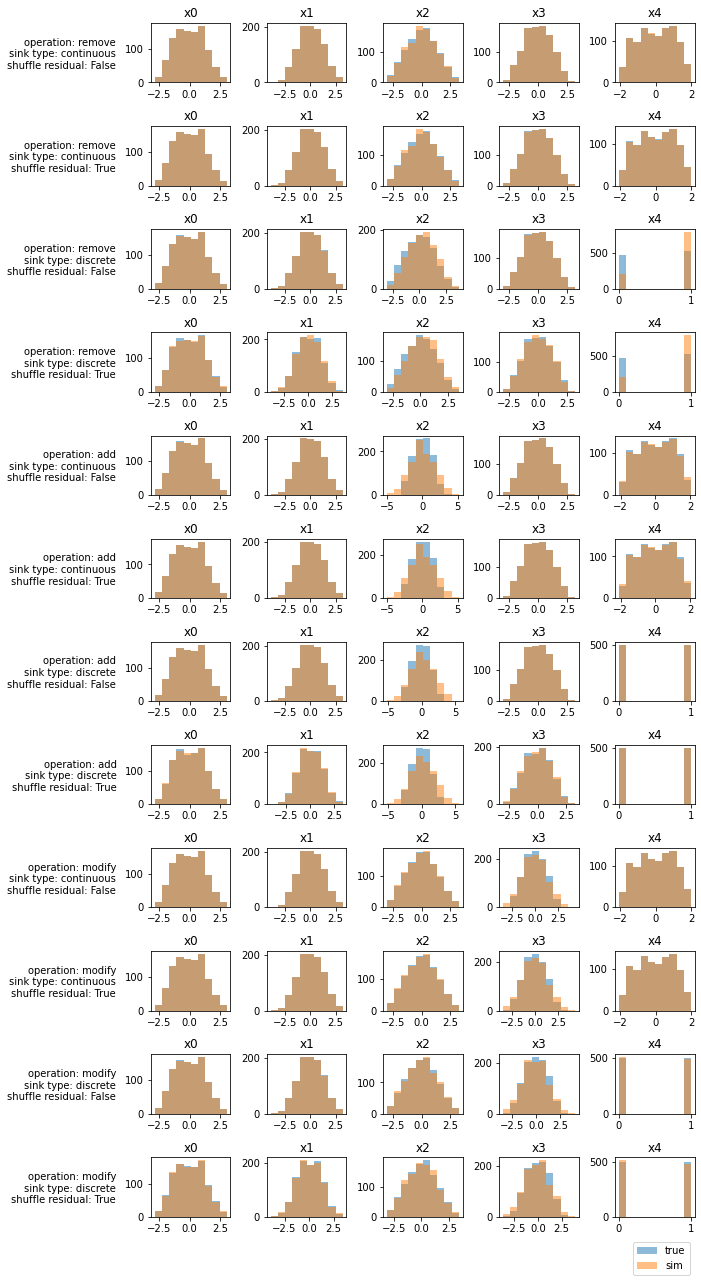

In [18]:
# シミュレーションの様子
n_features = causal_graph_true.shape[1]
n_patterns = len(results) * len(results["add"])

fig, axes = plt.subplots(n_patterns, n_features, figsize=(n_features*2, n_patterns*1.5))
count = 0

for name, result in results.items():
    for name2, result2 in result.items():
        evals, predicted_values, simulated, X = result2
        
        ax = axes[count]
        for i, (true, sim) in enumerate(zip(X.T, simulated.values.T)):
            range_ = min(*true, *sim), max(*true, *sim)
            ax[i].hist(true, range=range_, label="true", alpha=0.5)
            ax[i].hist(sim, range=range_, label="sim", alpha=0.5)
            ax[i].set_title(f"x{i}")

            if count == 0:
                ax[i].set_title(f"x{i}")
            if i == 0:
                s = "operation: " + name + "\n"
                s += "sink type: " + name2.split("_")[0] + "\n"
                s += "shuffle residual: " + ("True" if len(name2.split("_")) == 2 else "False") + "\n"
                ax[i].text(-6, 0, s, ha="right", va="bottom")
            if count == n_patterns - 1 and i == n_features - 1:
                ax[i].legend(bbox_to_anchor=(1, -0.7), loc="center right")
        count += 1

plt.tight_layout()
plt.show()

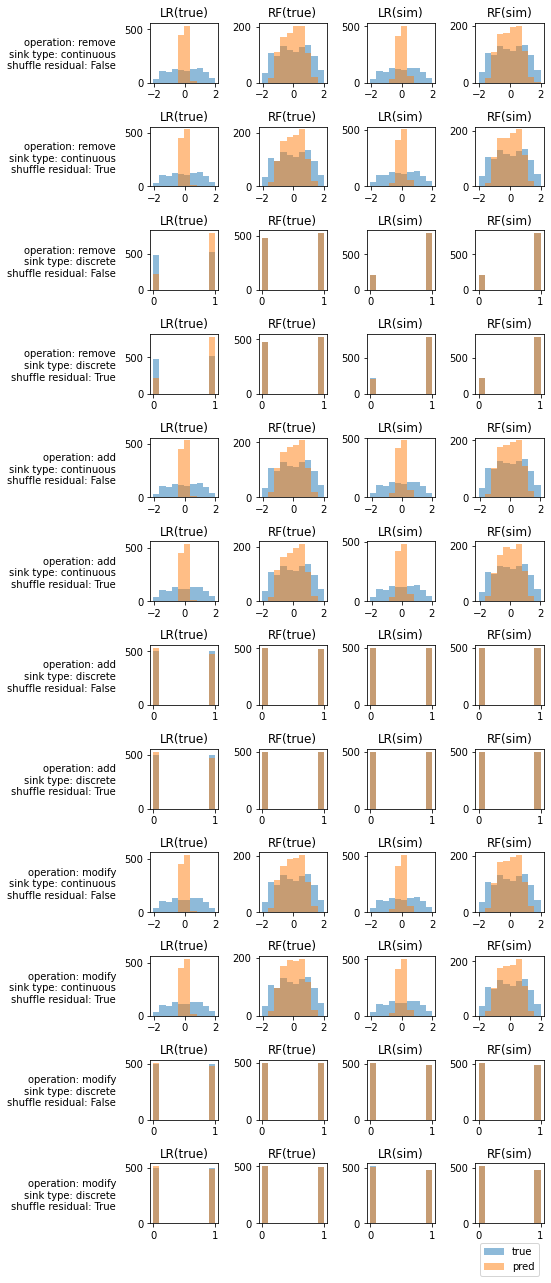

In [19]:
# 機械学習による予測の様子
n_features = len(causal_graph_true)
n_patterns = len(results) * len(results["add"])
n_rows = 4

fig, axes = plt.subplots(n_patterns, n_rows, figsize=(n_rows*2, n_patterns*1.5))
count = 0

for name, result in results.items():
    for name2, result2 in result.items():
        evals, predicted_values, simulated, X = result2
        
        ax = axes[count]
        
        def _draw_hist(ax, true, pred):
            # XXX: 離散はconfusion matrix
            range_ = min(*true, *pred), max(*true, *pred)
            ax.hist(true, alpha=0.5, label="true", range=range_)
            ax.hist(pred, alpha=0.5, label="pred", range=range_)
        
        # 真のデータに対する機械学習
        values = predicted_values[("lr", "true")]
        _draw_hist(ax[0], values["true"], values["pred"])
        ax[0].set_title("LR(true)")
        values = predicted_values[("rf", "true")]
        _draw_hist(ax[1], values["true"], values["pred"])
        ax[1].set_title("RF(true)")
        
        # シミュレーションデータに対する機械学習
        values = predicted_values[("lr", "sim")]
        _draw_hist(ax[2], values["true"], values["pred"])
        ax[2].set_title("LR(sim)")
        values = predicted_values[("rf", "sim")]
        _draw_hist(ax[3], values["true"], values["pred"])
        ax[3].set_title("RF(sim)")
                
        # 実験条件
        l, r = ax[0].get_xlim()
        offset = (r - l) * 0.5
        s = "operation: " + name + "\n"
        s += "sink type: " + name2.split("_")[0] + "\n"
        s += "shuffle residual: " + ("True" if len(name2.split("_")) == 2 else "False") + "\n"
        ax[0].text(l - offset, 0, s, ha="right", va="bottom")
        
        if count == n_patterns - 1:
            ax[3].legend(bbox_to_anchor=(1, -0.6), loc="center right")
            
        count += 1

plt.tight_layout()
plt.show()

In [20]:
# 結果の表(連続)
table = []
columns = ["operation", "model", "shuffle error", "MSE(true)", "MSE(sim)"]

for name, result in results.items():
    for name2, result2 in result.items():
        if not name2.startswith("continuous"):
            continue
        
        evals, predicted_values, simulated, X = result2
        
        is_shuffle = len(name2.split("_")) > 1
        
        # lr
        mse_true = evals[('lr', 'mse', 'true')]
        mse_sim = evals[('lr', 'mse', 'sim')]
        table.append((name, "LinearRegression", str(is_shuffle), f"{mse_true:.3f}", f"{mse_sim:.3f}"))
        
        # rf
        mse_true = evals[('rf', 'mse', 'true')]
        mse_sim = evals[('rf', 'mse', 'sim')]
        table.append((name, "RandomForestRegressor", str(is_shuffle), f"{mse_true:.3f}", f"{mse_sim:.3f}"))
        
pd.DataFrame(table, columns=columns).style.hide(axis="index")

operation,model,shuffle error,MSE(true),MSE(sim)
remove,LinearRegression,False,0.966,0.954
remove,RandomForestRegressor,False,0.145,0.142
remove,LinearRegression,True,0.966,0.954
remove,RandomForestRegressor,True,0.146,0.141
add,LinearRegression,False,0.966,0.954
add,RandomForestRegressor,False,0.145,0.140
add,LinearRegression,True,0.966,0.954
add,RandomForestRegressor,True,0.144,0.142
modify,LinearRegression,False,0.966,0.954
modify,RandomForestRegressor,False,0.143,0.142


In [21]:
# 結果の表(離散)
table = []
columns = ["operation", "model", "shuffle error", "precision(true)", "precision(sim)", "recall(true)", "recall(sim)"]

for name, result in results.items():
    for name2, result2 in result.items():
        if not name2.startswith("discrete"):
            continue
        
        evals, predicted_values, simulated, X = result2
        
        is_shuffle = len(name2.split("_")) > 1
        
        # lr
        precision_true = evals[('lr', 'precision', 'true')]
        precision_sim = evals[('lr', 'precision', 'sim')]
        recall_true = evals[('lr', 'recall', 'true')]
        recall_sim = evals[('lr', 'recall', 'sim')]
        table.append(
            (name, "LogisticRegression", str(is_shuffle),
             f"{precision_true:.3f}", f"{precision_sim:.3f}", f"{recall_true:.3f}", f"{recall_sim:.3f}")
        )
        
        # rf
        precision_true = evals[('rf', 'precision', 'true')]
        precision_sim = evals[('rf', 'precision', 'sim')]
        recall_true = evals[('rf', 'recall', 'true')]
        recall_sim = evals[('rf', 'recall', 'sim')]
        table.append(
            (name, "RandomForestRegressor", str(is_shuffle),
             f"{precision_true:.3f}", f"{precision_sim:.3f}", f"{recall_true:.3f}", f"{recall_sim:.3f}")
        )
        
pd.DataFrame(table, columns=columns).style.hide(axis="index")

operation,model,shuffle error,precision(true),precision(sim),recall(true),recall(sim)
remove,LogisticRegression,False,0.546,0.996,0.816,0.997
remove,RandomForestRegressor,False,1.000,1.000,1.000,1.000
remove,LogisticRegression,True,0.546,0.995,0.816,0.997
remove,RandomForestRegressor,True,1.000,1.000,1.000,1.000
add,LogisticRegression,False,0.548,0.994,0.517,0.994
add,RandomForestRegressor,False,1.000,1.000,1.000,1.000
add,LogisticRegression,True,0.548,0.998,0.517,0.994
add,RandomForestRegressor,True,1.000,1.000,1.000,1.000
modify,LogisticRegression,False,0.546,0.990,0.533,0.998
modify,RandomForestRegressor,False,1.000,1.000,1.000,1.000
